I've recently been teaching myself to use the MCMC library [PyMC](https://pymc-devs.github.io/pymc3/), and had some confusion when trying to solve a (seemingly) simple inference problem. 
The purpose of this blog post to clear up that confusion.

I'll assume the reader is familiar with Bayes' Theorem and how it might be applied to reassign probabilities to hypotheses after observing data.

First let's import the usual libraries, as well as my own utils functions for plotting.

In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import utils
%matplotlib inline

## Coin bias inference example

As a simple illustration of the way in which you build up models in PyMC, let's look at the typical problem of infering the bias of a coin.

In [7]:
true_coin_bias = 0.5 # The (unknown) bias of the coin
num_flips = 100

# The given data, the result of 100 coin flips
data = np.random.choice([0, 1], p=[1-true_coin_bias, true_coin_bias], size=num_flips)

# We want to infer the bias, p.
# Since p is unknown, it is a random variable.
# The distribution we assign to it here is our prior distribution on p, uniform on the range [0, 1].
p = pm.Uniform("p", lower=0, upper=1)

# We need another random variable for our observations.
# We give the relevant data to the value argument.
# The observed flag stops the value changing during MCMC exploration.
observations = pm.Bernoulli("obs", p=p, value=data, observed=True)

model = pm.Model([p, observations])

So far, we have stated our prior distribution on $p$, and declared that the likelihood function of each of our coin flip observations is a Bernoulli distribution with $p$ as its parameter. When we tell PyMC to do MCMC sampling, it samples from the distribution proportional to the product of these terms, i.e., the posterior distribution on $p$.

Graphically, the model looks as follows. Each node in the graph is a random variable. Arrows indicate parent/child relationships, and grey nodes are 'observed'.

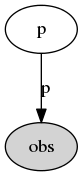

In [8]:
utils.display_graph(model)

The next step is to tell PyMC to perform MCMC sampling. The histogram of samples approximates the posterior. The black line shows the true value.

 [-----------------100%-----------------] 50000 of 50000 complete in 1.7 sec

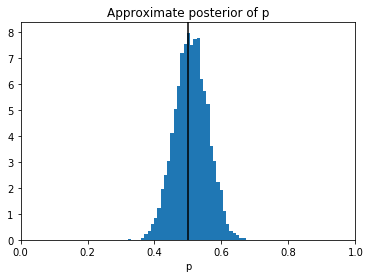

In [9]:
mcmc = pm.MCMC(model)
mcmc.sample(50000, 5000) # 50000 steps, with a burn in period of 5000

# Samples from our posterior on p
p_samples = mcmc.trace("p")[:]

plt.hist(p_samples, bins=40, normed=True)
plt.axvline(x=true_coin_bias, c="k")
plt.xlabel("p")
plt.title("Approximate posterior of p")
plt.xlim(0,1);

## Deterministic nodes

Next let's look at an example of a model which includes a deterministic node, that is, a node whose value is known if the values of its parent nodes are known. Such nodes do not contribute a term to the posterior.

In this example we have some samples from a normal distribution, and we will infer the standard deviation parameter of that normal distribution. 

In [10]:
true_sigma = 2.0 # The true (unknown) value of the standard deviation, sigma
num_samples = 500

# Some samples from the distribution
data = np.random.normal(scale=true_sigma, size=num_samples)

# Our prior on sigma. An exponential with expected value 1/beta = 100
sigma = pm.Exponential("sigma", beta=0.01)

# PyMCs Normal distribution accepts a precision parameter rather than a standard deviation or variance parameter. The precision tau = 1.0/sigma**2.
# For this we need a deterministic node, which can be set up as follows.
@pm.deterministic
def tau(sigma=sigma):
    return 1.0 / sigma**2

# A node for our observations, with a single parent parameter tau.
observations = pm.Normal("obs", 0, tau, value=data, observed=True)

model = pm.Model([sigma, observations])

The *@pm.deterministic* decorator sets up a deterministic node whose value is given by the function following the decorator, and whose parents are the parameters of that function.

Let's look at the graph of this model, in which the deterministic node in indicated with a triangle.

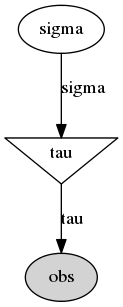

In [11]:
utils.display_graph(model)

Sigma is a random variable which we have a prior over. The value of Tau depends deterministically on Sigma. Our observations are random variables the likelihood function of which takes Tau as a parameter. The Tau node does not contribute directly to the posterior. When we tell PyMC to perform MCMC sampling, we sample from the distribution proportional to the prior over Sigma multiplied by the likelihood functions of the observations.

Now let's perform MCMC sampling and look at the histogram of samples from the posterior. Again, the black line shows the true value.

 [-----------------100%-----------------] 50000 of 50000 complete in 2.4 sec

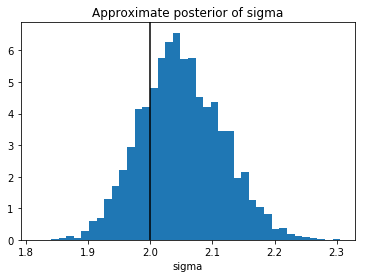

In [12]:
mcmc = pm.MCMC(model)
mcmc.sample(50000, 5000)

sigma_samples = mcmc.trace("sigma")[:]

plt.hist(sigma_samples, bins=40, normed=True);
plt.axvline(x=true_sigma, c="k")
plt.title("Approximate posterior of sigma")
plt.xlabel("sigma");

## The lighthouse problem

Consider the following problem adapted from Gull (1988). There exists a lighthouse $\alpha$ miles along a straight coastline (relative to some position $x=0$) and $\beta$ miles offshore. As it rotates, it briefly flashes highly collimated beams of light at random intervals. We have light detectors along the coastline, and so for the $k$th time the light flashes (not counting the times the light is facing *away* from the coast) we record a position $x_k$. Given a sequence of observations, infer the position coordinates $\alpha$ and $\beta$.

The relationships between all the variables for a single observation $x_k$ is shown below. Also shown is the angle $\theta_k$ that the $k$th beam makes with the line joining the lighthouse to the coast.

<img src="./img/lighthouse.png" width="300" />

### Creating the data

For simplicity, let's assume that each time the lighthouse flashes the angle of the beam is sampled uniformly between [$-\pi / 2$, $\pi / 2$].

We can see from the diagram that $\frac{x_k - \alpha}{\beta} = \tan{\theta_k}$, so $x_k = \alpha + \beta \tan{\theta_k}$. 

In [13]:
# The parameters to be inferred. We only know them here because we are synthesising the data.
true_alpha = 10
true_beta = 50

num_flashes = 50

# Generate the angles
true_thetas = np.random.uniform(low=-0.5*np.pi, high=0.5*np.pi, size=num_flashes)

# Generate the x coordinates of the flashes along the coastline
data = true_alpha + true_beta * np.tan(true_thetas)

### First modelling attempt

In [14]:
# Our prior distribution on alpha and beta.
# Alpha is normally distributed with a standard deviation of 50 miles.
# Beta is exponentially distributed with a mean value of 100 miles.
alpha = pm.Normal("alpha", 0, 1.0/50**2)
beta = pm.Exponential("beta", 1.0/100)
# We have a prior distribution for the angle of the lighthouse for every time we observed a flash, uniform over [-pi/2, pi/2]
thetas = pm.Uniform("thetas", lower=-0.5*np.pi, upper=0.5*np.pi, size=num_flashes)

Now what? In this case, the vector of observations would be a deterministic function of alpha, beta, and the vector of angles, which we can set up as follows.

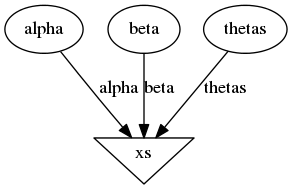

In [15]:
@pm.deterministic
def xs(alpha=alpha, beta=beta, thetas=thetas):
  return alpha + beta * np.tan(thetas)

model = pm.Model([alpha, beta, thetas, xs])
utils.display_graph(model)

The graph of the model looks like what we wanted. Note though that I didn't indicate that the vector *xs* was *observed*, or link it to the data we have collected.

This is because a node in PyMC cannot be simultaneously deterministic and observed. Why not? I'm not the only person to have been confused by this (other examples can be found here: [1](https://groups.google.com/forum/#!topic/pymc/gAImsliT34o) [2](http://stats.stackexchange.com/questions/56543/pymc-how-can-i-define-a-function-of-two-stochastic-variables-with-no-closed-fo) [3](http://stackoverflow.com/questions/40026052/observed-deterministic-in-pymc3) [4](http://stackoverflow.com/questions/26397835/pymc-observed-data-for-a-sum-of-random-variables))

In order to understand why this is not possible, we need to remind ourselves how MCMC sampling works.

First, the values of all stochastic, non-observed nodes are initialised randomly. Then, a new position in the space of possible values for each of these nodes is considered. Whether we move to the new location depends on the value of the posterior distribution at the old location and at the new location, and this process is repeated.

Note that because *xs* is a deterministic function of its parents, the likelihood function for a given value of $x$, $p(x|\alpha, \beta, \theta)$ is *zero* for almost all values of $\alpha$, $\beta$, and $\theta$. As a result, the posterior distribution is also zero almost everywhere. Since almost everywhere the MCMC process looks, it sees a posterior probability of zero, it has no way to explore the space effectively.

There is a solution, but unfortunately we can't avoid doing a bit of work here. If we have a pdf $f(x)$ for the random variable $X$, then the pdf for the random variable $Y(X)$ is $f(x(y))\frac{dx}{dy}$.

[TODO: clarify]

$f(\theta)$ is $1/\pi$ in the range [$-\pi/2, \pi/2$].

The pdf over $x$ is $\frac{\beta}{\pi (\beta^2 + (\alpha - x)^2)}$, defined over [$-\infty, \infty$], and is plotted below.

The log probability is then $\log(\beta) - \log(\pi) - \log((\alpha - x)^2)$.

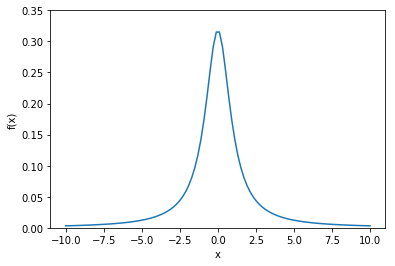

In [13]:
def x_pdf(x, alpha, beta):
  return beta / (np.pi * (beta**2 + (alpha - x)**2))

xs = np.linspace(-10,10,100)
ps = np.vectorize(x_pdf)(xs, 0.0, 1.0)
plt.ylim(0, 0.35)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(xs, ps);

The proper way to define the model then is as follows.

The *@pm.stochastic* decorator sets up a stochastic node whose log-probability is as defined in the function that follows it. The first parameter of that function is the initial value, and the remaining parameters are the parent nodes. We can set the node to be *observed* by setting a flag within the decorator.

Since the function is to return the log probability of our vector of observations, we compute the vector of log probabilities and take the sum.

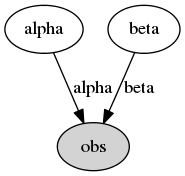

In [39]:
alpha = pm.Normal("alpha", 0, 1.0/50**2)
beta = pm.Exponential("beta", 1.0/100)

@pm.stochastic(name="obs", dtype=np.float64, observed=True)
def obs(value=data, alpha=alpha, beta=beta):
    return np.sum(np.log(beta) - np.log(np.pi) - np.log(beta**2 + (alpha-value)**2))

model = pm.Model([alpha, beta, obs])
utils.display_graph(model)

Now let's perform MCMC sampling and visualise the result.

The contour plot is an illustration of the posterior distribution over *alpha* and *beta*. The thick black line at the bottom of the plot illustrates the location of the coastline, with the yellow dots showing the locations where beam flashes were detected. The large black dot shows the true location of the lighthouse.

 [-----------------100%-----------------] 20000 of 20000 complete in 1.5 sec

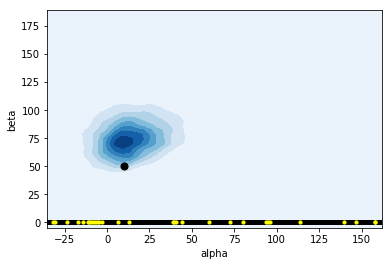

In [40]:
mcmc = pm.MCMC(model)
mcmc.sample(20000, 2000)

alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]
utils.plot_lighthouse_posterior(alpha_samples, beta_samples, data, true_alpha, true_beta)